In [14]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter as sgf

smoothing_window = 7
smoothing_order = 2

def deriv(p, w):
    return p - np.roll(p,w)

folder = r''

OS_metadata = pd.read_csv('reference_absorbance_raw_metadata.csv', encoding='latin1')
OS_library = pd.read_csv('reference_absorbance_raw.csv')
OS_library = OS_library[((OS_library['wavenumber']<2300) | (OS_library['wavenumber']>2400)) & (OS_library['wavenumber']>900)]
OS_library = OS_library.sort_values(by=['wavenumber'])
OS_metadata = OS_metadata[OS_metadata['SpectrumType']=='FTIR']

OS_int = pd.DataFrame()
OS_derivative = pd.DataFrame()
wavenos = np.array(range(900,4000,1))
OS_int['wavenos'] = wavenos
OS_int.set_index('wavenos')

OS_derivative['wavenos'] = wavenos
OS_derivative.set_index('wavenos')

OS_library

,wavenumber,intensity,sample_name
18859275,900.000012,0.133510,b826e94d75e66fbf3885d38f20d2dc21
22660335,900.000012,3.854880,c5b090627048e93d987d11f0ff628072
28448492,900.000154,3.201210,3037666223719e1157c6e0688fabb2f2
17573997,900.000154,1.229470,acd9308cb967cbeeafe4574222448290
21289867,900.000154,3.201210,b25cd3333e5c5ba401fcdbcc667df7cf
...,...,...,...
546732,7498.994300,0.060215,6c74c793ff1aacdb38d2353364a6295b
840001,7498.997300,5.586848,be5db3aaf5d687e6a3a693be675ea2e0
875764,7498.997300,0.066966,eec7e6865b66a7b256ded7db506e2761
940140,7498.997300,0.026155,c6e6843bf888b5b81c7cf8f40750c76a


In [31]:
grouped = OS_library.groupby(['sample_name'])

In [25]:
names = list(set(OS_library['sample_name']))
names[0]

'7845faf1bdee7d446eb351203cb61a55'

In [100]:
def interpolator(frame):
    try:
        sigint = np.interp(wavenos,frame['wavenumber'],frame['intensity'])
    except ValueError: sigint = np.zeros(len(wavenos))
    sigint = sigint - np.min(sigint)
    #der_sigint = sgf(deriv(sigint,smoothing_window),smoothing_window,smoothing_order)
    print('frame')
    return pd.Series(sigint)

def deriv_smth(ser):
    return pd.Series(sgf(deriv(ser,smoothing_window),smoothing_window,smoothing_order))


In [89]:
%%capture
OS_intT = grouped.apply(interpolator)
#import matplotlib.pyplot as plt
#plt.plot(OS_int[5544])

OS_int = OS_intT.T.set_axis(wavenos)
OS_int.index.names=['wavenumbers']


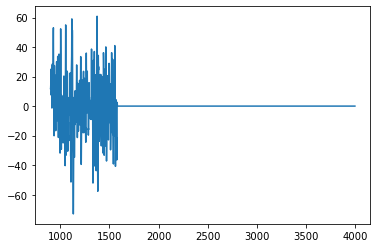

In [107]:
OS_der = OS_int.apply(deriv_smth,axis=0)

OS_der = OS_der.set_axis(wavenos)
OS_der.index.names=['wavenumbers']


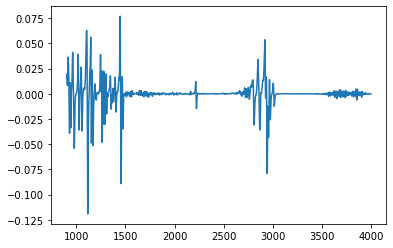

In [110]:

plt.plot(OS_der['000a8932dd90f908f8108d2ade8b2140'])

In [ ]:

for name in OS_metadata['sample_name']:
    wn = OS_library[OS_library['sample_name']==name].sort_values(by='wavenumber')['wavenumber']
    sig = OS_library[OS_library['sample_name']==name].sort_values(by='wavenumber')['intensity']
    try:
        sigint = np.interp(wavenos,wn,sig)
    except ValueError: np.zeros(len(wavenos))
    sigint = sigint - np.min(sigint)
    OS_int[name] = sigint
    der_sigint = sgf(deriv(sigint,smoothing_window),smoothing_window,smoothing_order)
    OS_derivative[name] = der_sigint
    print(name)


file_int = 'open_specy_ftir_library_INTv2.csv'
file_der = 'open_specy_ftir_library_DERINTv2.csv'

OS_int.to_csv(file_int, index=False)
OS_derivative.to_csv(file_der, index=False)

print(OS_derivative)